In [93]:
import os
import polars as pl
import matplotlib.pyplot as plt

## 1. Load data

#### 1.1. Read and concat data

In [94]:
taxi_data = pl.scan_csv("data/taxi+_zone_lookup.csv")

In [95]:
taxi_df = []

for month in range(1, 13):
    file_path = f"data/{month}.parquet"
    if os.path.exists(file_path):
        df_month = pl.scan_parquet(file_path)
        df_month = df_month.with_columns([
            pl.col("tpep_pickup_datetime").dt.cast_time_unit("ms"),
            pl.col("tpep_dropoff_datetime").dt.cast_time_unit("ms")
        ])
        taxi_df.append(df_month)

df = pl.concat(taxi_df)

df = df.filter(
    pl.col("tpep_pickup_datetime").dt.year() == 2024,
    pl.col("tpep_dropoff_datetime") <= pl.lit("2025-01-01").str.strptime(pl.Date, "%Y-%m-%d")
)

#### 1.2. Select proper columns

In [96]:
df = df.with_columns(
    pl.col("VendorID").cast(pl.Int8),
    pl.col("passenger_count").cast(pl.Int8),
    pl.col("RatecodeID").cast(pl.Int8),
    pl.col("PULocationID").cast(pl.Int16),
    pl.col("DOLocationID").cast(pl.Int16),
    pl.col("payment_type").cast(pl.Int8),
    pl.col("store_and_fwd_flag").cast(pl.Categorical),
    pl.col("fare_amount").cast(pl.Float32),
    pl.col("extra").cast(pl.Float32),
    pl.col("mta_tax").cast(pl.Float32),
    pl.col("tip_amount").cast(pl.Float32),
    pl.col("tolls_amount").cast(pl.Float32),
    pl.col("improvement_surcharge").cast(pl.Float32),
    pl.col("total_amount").cast(pl.Float32),
    pl.col("congestion_surcharge").cast(pl.Float32),
    pl.col("Airport_fee").cast(pl.Float32),
    pl.col("trip_distance").cast(pl.Float32),
)

## 2. Data cleaning

#### 2.1. Fixing money related cols - abs value. Values less than 1000

In [97]:
money_related = [
    "fare_amount",
    "extra",
    "mta_tax",
    "tip_amount",
    "tolls_amount",
    "improvement_surcharge",
    "total_amount",
    "congestion_surcharge",
    "Airport_fee"
]

for col in money_related:
    df = df.with_columns(
        pl.col(col).abs().alias(col)
    )
    df = df.filter(
        pl.col(col) <= 1000
    )

#### 2.2. Applying rest of fixes

In [98]:
df = df.filter(
    pl.col("passenger_count") > 0,
    (pl.col("tpep_dropoff_datetime") - pl.col("tpep_pickup_datetime")).dt.total_minutes() <= 120,
    pl.col("VendorID").is_in([1, 2]),
    pl.col("RatecodeID").is_in([1, 2, 3, 4, 5, 6]),
)

## 3. Data transformation

#### 3.1. Payment_type for others, is_airport_ride, is_rush_hour added

In [99]:
df_transformed = (
    df.with_columns([
        pl.when(pl.col("payment_type") == 1)
          .then(pl.lit("credit"))
          .when(pl.col("payment_type") == 2)
          .then(pl.lit("cash"))
          .otherwise(pl.lit("other"))
          .alias("payment_type"),

        (pl.col("Airport_fee") > 0).alias("is_airport_ride"),

        pl.when(pl.col("tpep_pickup_datetime").dt.weekday() <= 5)
          .then(
              (
                  ((pl.col("tpep_pickup_datetime").dt.hour() + pl.col("tpep_pickup_datetime").dt.minute() / 60).is_between(6.5, 9.5))
                  | ((pl.col("tpep_pickup_datetime").dt.hour() + pl.col("tpep_pickup_datetime").dt.minute() / 60).is_between(15.5, 20.0))
              )
          )
          .otherwise(False)
          .alias("is_rush_hour"),
    ])
)

## 4. Feature extraction

#### All in one :)

In [100]:
df_transformed = df_transformed.select(pl.all())

df_ext = (
    df_transformed
    .group_by(pl.col("tpep_pickup_datetime").dt.date().alias("date"))
    .agg([
        pl.len().alias("total_rides"),
        pl.col("is_airport_ride").sum().alias("airport_rides"),
        pl.col("is_rush_hour").sum().alias("rush_hour_rides"),
        pl.col("fare_amount").mean().alias("avg_fare_amount"),
        pl.col("trip_distance").median().alias("median_distance"),
        pl.col("total_amount").sum().alias("sum_total_amount"),
        pl.col("congestion_surcharge").sum().alias("total_congestion_surcharge"),
        pl.col("passenger_count").sum().alias("total_passengers"),
    ])
    .with_columns([
        pl.col("date").dt.quarter().alias("quarter"),
        pl.col("date").dt.month().alias("month"),
        pl.col("date").dt.day().alias("day_of_month"),
        pl.col("date").dt.weekday().alias("day_of_week"),
        (pl.col("date").dt.weekday() >= 5).alias("is_weekend"),
    ])
    .sort("date")
)

df_ext = df_ext.collect()

df_ext.write_parquet("dataset.parquet")


## 5. Data analysis

In [101]:
df_final = pl.read_parquet("dataset.parquet")

#### 5.1. Statystyki

In [102]:
print(df_final.shape)
print(df_final.head())
print(df_final.describe())
print(df_final.schema)

(366, 14)
shape: (5, 14)
┌────────────┬────────────┬────────────┬───────────┬───┬───────┬───────────┬───────────┬───────────┐
│ date       ┆ total_ride ┆ airport_ri ┆ rush_hour ┆ … ┆ month ┆ day_of_mo ┆ day_of_we ┆ is_weeken │
│ ---        ┆ s          ┆ des        ┆ _rides    ┆   ┆ ---   ┆ nth       ┆ ek        ┆ d         │
│ date       ┆ ---        ┆ ---        ┆ ---       ┆   ┆ i8    ┆ ---       ┆ ---       ┆ ---       │
│            ┆ u32        ┆ u32        ┆ u32       ┆   ┆       ┆ i8        ┆ i8        ┆ bool      │
╞════════════╪════════════╪════════════╪═══════════╪═══╪═══════╪═══════════╪═══════════╪═══════════╡
│ 2024-01-01 ┆ 69541      ┆ 8352       ┆ 19415     ┆ … ┆ 1     ┆ 1         ┆ 1         ┆ false     │
│ 2024-01-02 ┆ 71444      ┆ 9828       ┆ 30654     ┆ … ┆ 1     ┆ 2         ┆ 2         ┆ false     │
│ 2024-01-03 ┆ 78399      ┆ 9140       ┆ 33060     ┆ … ┆ 1     ┆ 3         ┆ 3         ┆ false     │
│ 2024-01-04 ┆ 97896      ┆ 8270       ┆ 43267     ┆ … ┆ 1     ┆ 4

#### 5.2. Histogram liczby przejazdów

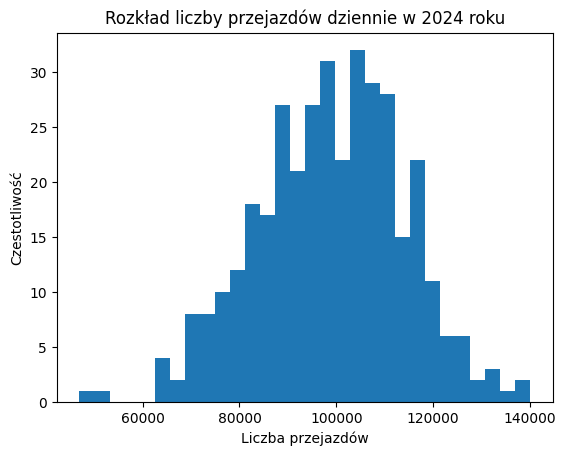

In [106]:
plt.hist(df_final["total_rides"], bins=30)
plt.title("Rozkład liczby przejazdów dziennie w 2024 roku")
plt.xlabel("Liczba przejazdów")
plt.ylabel("Czestotliwość")
plt.show()

#### 5.3. Wykres dzienny liczby przejazdów

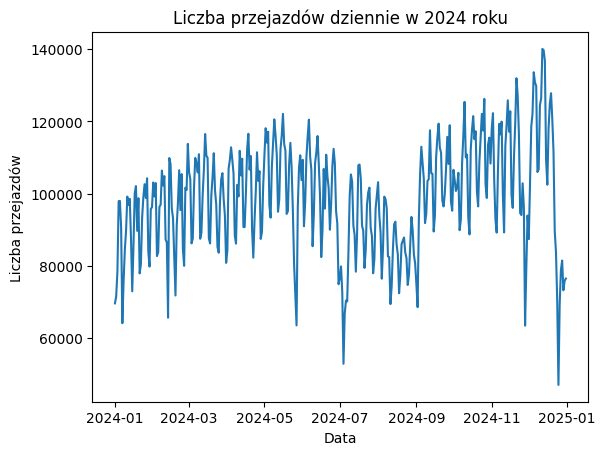

In [105]:
plt.plot(df_final["date"], df_final["total_rides"])
plt.title("Liczba przejazdów dziennie w 2024 roku")
plt.xlabel("Data")
plt.ylabel("Liczba przejazdów")
plt.show()